In [73]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision.ops import MLP
import torch_geometric
from torch_geometric.data import Data, Dataset, Batch
from torch_geometric.transforms import BaseTransform, AddRandomWalkPE
from torch.nn import functional as F
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.utils import to_dense_batch, degree
import random
from copy import deepcopy
import os
import os.path as osp
from tqdm.notebook import tqdm

# Data generation

In [74]:
def wilson_algorithm(G, start):
    """
    Wilson's algorithm for generating a uniform spanning tree on a graph.

    Parameters:
    - G: NetworkX graph
    - start: starting node for the algorithm

    Returns:
    - T: Uniform spanning tree of G
    """
    U = {start}
    T = deepcopy(G)
    nx.set_edge_attributes(T, {e:{"edge_weight":0.} for e in T.edges(data=False)})
    nx.set_node_attributes(T, {n:{'pos':n} for n in T.nodes(data=False)})
    while len(U) < len(G.nodes):
        u = random.choice(list(set(G.nodes) - U))
        path = [u]
        while u not in U:
            u = random.choice(list(G.neighbors(u)))
            if u in path:
                cycle_index = path.index(u)
                path = path[:cycle_index + 1]
            else:
                path.append(u)
        U.update(path)
        nx.set_edge_attributes(T, {(path[i], path[i + 1]):{"edge_weight":1.} for i in range(len(path) - 1)})
    return T

def generate_ust_maze(width, height):
    """
    Generates a maze using Wilson's algorithm.

    Parameters:
    - width: width of the maze
    - height: height of the maze

    Returns:
    - T: Uniform spanning tree representing the maze
    """
    G = nx.grid_2d_graph(width, height)
    start = (random.randint(0, width-1), random.randint(0, height-1))
    T = wilson_algorithm(G, start)
    return T

def generate_ust_maze_list(size, width, height):
    """
    Generates a maze dataset

    Parameters:
    - width: width of the maze
    - height: height of the maze

    Returns:
    - L a list of maze
    """
    L = []
    for i in range(size):
        L.append(generate_ust_maze(width, height))
    
    return L

def write_ust_maze_list(L, dir_name):
    """
    Writes a list of mazes in a specified file

    Parameters:
    - L: list of ust mazes
    - dir_name: The name of the directory to write the list
    """

    for i, G in enumerate(L):
        nx.write_gml(G, dir_name+"/Graph_"+str(i), stringizer=nx.readwrite.gml.literal_stringizer)

def draw_maze(T, width, height):
    """
    Draw the maze represented by the uniform spanning tree T.

    Parameters:
    - T: Uniform spanning tree representing the maze
    - width: width of the maze
    - height: height of the maze
    """
    pos = {n:pos for (n,pos) in nx.get_node_attributes(T, "pos").items()}
    real_edges = [e for (e,v) in nx.get_edge_attributes(T, "edge_weight").items() if v==1]
    plt.figure(figsize=(10, 10))
    nx.draw(T.edge_subgraph(real_edges), pos=pos, with_labels=False, node_size=10, width=2, edge_color='blue')
    plt.xlim(-1, width)
    plt.ylim(-1, height)
    plt.gca().invert_yaxis()
    plt.show()

def draw_Data(G, width, height):
    """
    Draw ther maze represented by the graph G

    Parameters:
    - G: torch_geometric graph
    - width: width of the maze
    - height: height of the maze
    """

    T = to_networkx(G, to_undirected=True, node_attrs=['pos'], edge_attrs=['edge_weight'])
    draw_maze(T, width, height)

# Dataset

In [75]:
class Maze_dataset(Dataset):
    """
    A class to represent a Dataset of maze
    """
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, force_reload=False):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.pre_transform = pre_transform
        self.transform = transform
        self.pre_filter = pre_filter
        self.root = root

    @property
    def raw_file_names(self):
        return [f for f in os.listdir(self.root+"/raw")]

    @property
    def processed_file_names(self):
        return [f for f in os.listdir(self.root+"/processed")]

    def process(self):
        idx = 0
        for raw_path in self.raw_paths:
            # Read data from `raw_path`.
            raw_graph = nx.read_gml(raw_path)

            data = from_networkx(raw_graph)

            data.edge_index, data.edge_weight = torch_geometric.utils.coalesce(edge_index=data.edge_index, edge_attr=data.edge_weight)

            data.edge_state = torch.hstack((data.edge_weight.unsqueeze(1), 1. - data.edge_weight.unsqueeze(1))) #Binary state space

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data
    
    def get_raw(self, idx):
        G = nx.read_gml(osp.join(self.raw_dir, f'Graph_{idx}'), destringizer=nx.readwrite.gml.literal_destringizer)
        return G

In [76]:
#L = generate_ust_maze_list(1000, 32, 32)
#write_ust_maze_list(L, "D3PM/Ddataset32/raw")

In [77]:
dataset = Maze_dataset("D3PM/Ddataset32")

/tmp/ipykernel_925887/922136810.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))


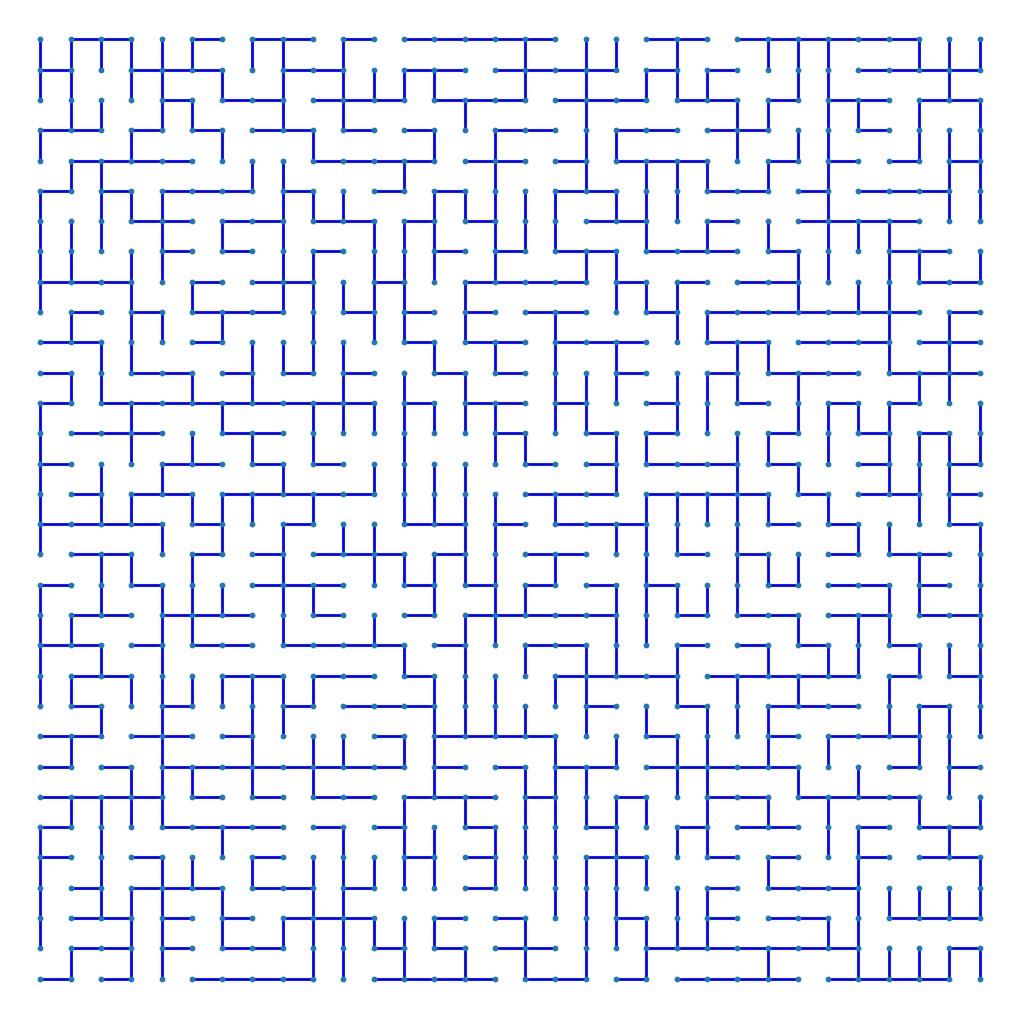

In [78]:
draw_Data(dataset[0], 32, 32)

# Model design

In [79]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [80]:
class D3PM(nn.Module):
    """
    A class to represent a diffusion model using the network parameter as a denoiser.
    """
    def __init__(self, network, num_timesteps, device=device):
        super(D3PM, self).__init__()
        self.num_timesteps = num_timesteps
        s = 1e-3
        t = torch.linspace(0, num_timesteps, num_timesteps)
        self.betas_cumprod = (torch.square( torch.cos( 0.5 * torch.pi *( t/num_timesteps + s )/(1 + s) ) ) * 0.5 + 0.5).to(device)
        self.alphas_cumprod = 1 - self.betas_cumprod
        self.network = network
        self.device = device

    def add_noise(self, G_start, timesteps):

        noised_G = G_start.clone()

        timesteps = timesteps[G_start.batch[G_start.edge_index[0]]]

        betas = self.betas_cumprod[timesteps]
        alphas = self.alphas_cumprod[timesteps]

        states = G_start.edge_state

        p = betas * states[:,0] + alphas * states[:,1]
        
        undirected_indices = (noised_G.edge_index[0] < noised_G.edge_index[1]) * noised_G.csr()[2] + (noised_G.edge_index[0] >= noised_G.edge_index[1]) * noised_G.csc()[2] # To noise in a undirected way. 
        noised_G.edge_state = F.one_hot( torch.bernoulli(p)[undirected_indices].long() ) * 1. #Sample from the distribution p

        noised_G.edge_weight = noised_G.edge_state[:,0] #To do Message Passing only on noised edges

        return noised_G

    def reverse(self, batch, t):
        # The network estimates the noise added
        return self.network(batch, t)

    def sample(self, G_start, t):
        G_start.edge_state = self.reverse(G_start, t)
        
        return G_start

In [81]:
def sinusoidal_embedding(n, d):
    """
    Returns the sinusoidal positional encoding of dimension d for n timesteps.
    """
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [121]:
class AddEdgeStatePE(BaseTransform):
    """
    A transform class to add data about adjacent edges state in each nodes' embedding

    This implementation is not efficient at all it is just meant for little tests, which aren't conclusive.
    """
    def __init__(self, emb, emb_dim, max_deg) -> None:
        self.max_deg = max_deg
        self.emb_dim = emb_dim
        self.emb = emb
        self.rw = AddRandomWalkPE(walk_length=4*max_deg)

    def forward(self, data) -> Data:
        data, t = data
        assert data.edge_index is not None
        assert data.edge_state is not None
        assert data.batch is not None

        adjacent_edges = to_dense_batch(data.edge_state, data.edge_index[0])[0] #For each node, the states of its adjacent edges (in the underlying graph)
        adjacent_edges = torch.flatten(adjacent_edges, start_dim=1)

        real_edges_mask = data.edge_weight == 1. #To consider only the edges of the noised graph (not of the underlying graph)

        real_src = data.edge_index[0][real_edges_mask]
        real_dest = data.edge_index[1][real_edges_mask]

        node_degree = degree(real_src, num_nodes=data.num_nodes) #Compute de degree of each node

        neighbors_degree = to_dense_batch(x=node_degree[real_dest], batch=real_src, batch_size=data.num_nodes, max_num_nodes=self.max_deg)[0] #Compute, for each node the degree of its neighbors

        data.x = torch.zeros((data.num_nodes, self.emb_dim)).to(device)
        data.x[:, : 2*self.max_deg] = adjacent_edges
        data.x[:, 2*self.max_deg: 2*self.max_deg + 1] = node_degree.unsqueeze(1)
        data.x[:, 2*self.max_deg + 1 : 2*self.max_deg + 1 + self.max_deg] = neighbors_degree
        data = self.rw(data)

        data.x = data.x + self.emb[t[data.batch]] #Add sinusoidal PE

        return data

In [122]:
class Network(nn.Module):
    """
    A basic GNN model to denoise in the diffusion process.
    """
    def __init__(self, max_deg=4, n_steps=1000, time_emb_dim=100, num_gcn_layers=3, num_mlp1_layers=2, num_mlp2_layers=2):
        super().__init__()
        self.feature_size = time_emb_dim

        self.mlp1 = MLP(in_channels=self.feature_size, hidden_channels=[self.feature_size for _ in range(num_mlp1_layers)])
        self.GNN = torch_geometric.nn.GCN(in_channels=self.feature_size, 
                                          hidden_channels=2*self.feature_size, 
                                          num_layers=num_gcn_layers, 
                                          out_channels=2*self.feature_size,
                                         )
        
        self.mlp2 = MLP(in_channels=4*self.feature_size, hidden_channels=[4*self.feature_size for _ in range(num_mlp2_layers)]+[1])
        self.sig = torch.nn.Sigmoid()

        self.time_embedding = sinusoidal_embedding(n_steps, time_emb_dim).to(device)
        self.transform = AddEdgeStatePE(max_deg=4, emb_dim=time_emb_dim, emb=self.time_embedding)
    
    def forward(self, batch, t):
        batch = self.transform((batch, t))

        y = self.mlp1(batch.x)
        y = self.GNN(x=y, edge_index=batch.edge_index, edge_weight=batch.edge_weight)
        y = torch.cat((y[batch.edge_index[0]].T, y[batch.edge_index[1]].T)).T
        out = self.mlp2(y)

        return self.sig(out).reshape(-1)

In [123]:
num_timesteps = 1000
time_emb_dim = 100
batch_size = 1
data_size = 1000
num_gcn_layers = 3
num_mlp1_layers = 2
num_mlp2_layers = 2

network = Network(max_deg=4, n_steps=num_timesteps, time_emb_dim=time_emb_dim, num_gcn_layers=num_gcn_layers, num_mlp1_layers=num_mlp1_layers, num_mlp2_layers=num_mlp2_layers)

model = D3PM(network, num_timesteps)
#model.load_state_dict(torch.load('model_weights.pth', weights_only=True))

train_loader = torch_geometric.loader.DataLoader(dataset[:data_size], batch_size=batch_size, shuffle=True)

In [ ]:
num_epochs = 50
learning_rate = 0.001

optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCELoss()

losses = []
accs = []

model.to(device)
for epoch in range(num_epochs):
        model.train()
        running_loss = 0.
        running_acc = 0.
        # inside the training loop
        for step, batch in enumerate(train_loader):
                batch = batch.to(device)

                timesteps = torch.randint(0, num_timesteps, (batch.num_graphs,)).long().to(device)

                noisy = model.add_noise(batch, timesteps)
                noise_pred = model.reverse(batch=noisy, t=timesteps)

                loss = loss_fn(noise_pred, batch.edge_state[:,0])
                acc = torch.sum(1. * ((noise_pred > 0.5) == batch.edge_state[:,0])) / batch.num_edges

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
                running_loss += loss.item() / len(train_loader)
                running_acc += acc / len(train_loader)
                
        losses.append(running_loss)
        accs.append(running_acc)
        
        print("Currently at epoch n°:"+str(epoch)+", running loss is: "+str(running_loss)+"  and running acc: "+str(running_acc))
    
        if epoch % 10 == 0:
                torch.save(model.state_dict(), 'model_weights.pth')


/tmp/ipykernel_925887/922136810.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
/home/pberlure/minicon

Currently at epoch n°:0, running loss is: 0.6859012484550476  and running acc: tensor(0.5432, device='cuda:0')
Currently at epoch n°:1, running loss is: 0.6725763320922851  and running acc: tensor(0.5756, device='cuda:0')
Currently at epoch n°:2, running loss is: 0.6541432738304138  and running acc: tensor(0.6133, device='cuda:0')
Currently at epoch n°:3, running loss is: 0.6311229407787323  and running acc: tensor(0.6416, device='cuda:0')
Currently at epoch n°:4, running loss is: 0.6197739005088806  and running acc: tensor(0.6405, device='cuda:0')
Currently at epoch n°:5, running loss is: 0.6033410727977753  and running acc: tensor(0.6506, device='cuda:0')
Currently at epoch n°:6, running loss is: 0.597195941209793  and running acc: tensor(0.6538, device='cuda:0')
Currently at epoch n°:7, running loss is: 0.6022794663906097  and running acc: tensor(0.6483, device='cuda:0')
Currently at epoch n°:8, running loss is: 0.593475216627121  and running acc: tensor(0.6540, device='cuda:0')
Cur

In [ ]:
plt.plot(range(len(losses)), losses)
plt.title("BCELoss")
plt.show()
plt.title("Accuracy")
plt.plot(range(len(accs)), torch.tensor(accs))
plt.show()